# Montar las carpetas de google drive.
# Create environment in Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


# Funciones para ejecutar el código

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [6]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [9]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}

dataframes_path = 'melanoma_without_duplicates_separated_50/'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [12]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [13]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [14]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "/Pesos Resnet/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [15]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.conv1.weight
	 cnn.bn1.weight
	 cnn.bn1.bias
	 cnn.layer1.0.conv1.weight
	 cnn.layer1.0.bn1.weight
	 cnn.layer1.0.bn1.bias
	 cnn.layer1.0.conv2.weight
	 cnn.layer1.0.bn2.weight
	 cnn.layer1.0.bn2.bias
	 cnn.layer1.1.conv1.weight
	 cnn.layer1.1.bn1.weight
	 cnn.layer1.1.bn1.bias
	 cnn.layer1.1.conv2.weight
	 cnn.layer1.1.bn2.weight
	 cnn.layer1.1.bn2.bias
	 cnn.layer2.0.conv1.weight
	 cnn.layer2.0.bn1.weight
	 cnn.layer2.0.bn1.bias
	 cnn.layer2.0.conv2.weight
	 cnn.layer2.0.bn2.weight
	 cnn.layer2.0.bn2.bias
	 cnn.layer2.0.downsample.0.weight
	 cnn.layer2.0.downsample.1.weight
	 cnn.layer2.0.downsample.1.bias
	 cnn.layer2.1.conv1.weight
	 cnn.layer2.1.bn1.weight
	 cnn.layer2.1.bn1.bias
	 cnn.layer2.1.conv2.weight
	 cnn.layer2.1.bn2.weight
	 cnn.layer2.1.bn2.bias
	 cnn.layer3.0.conv1.weight
	 cnn.layer3.0.bn1.weight
	 cnn.layer3.0.bn1.bias
	 cnn.layer3.0.conv2.weight
	 cnn.layer3.0.bn2.weight
	 cnn.layer3.0.bn2.bias
	 cnn.layer3.0.downsample.0.weight
	 cnn.layer3.0

100%|██████████| 17/17 [00:28<00:00,  1.66s/it]


Epoch:  0 Train Loss: 0.73067923 AUC: 0.50911458 
[[0.37184116 0.62815884]
 [0.34220532 0.65779468]]


100%|██████████| 17/17 [00:35<00:00,  2.09s/it]


Epoch: 0 Val Loss: 0.72959521 AUC: 0.47435897 
[[0.93153153 0.06846847]
 [0.91619048 0.08380952]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch:  1 Train Loss: 0.72708908 AUC: 0.70555556 
[[0.67057762 0.32942238]
 [0.63498099 0.36501901]]


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 1 Val Loss: 0.72523641 AUC: 0.51923077 
[[0.95225225 0.04774775]
 [0.94       0.06      ]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch:  2 Train Loss: 0.72032183 AUC: 0.76645161 
[[0.7755716  0.2244284 ]
 [0.73700887 0.26299113]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 2 Val Loss: 0.71763357 AUC: 0.62820513 
[[0.95735736 0.04264264]
 [0.94285714 0.05714286]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch:  3 Train Loss: 0.70606995 AUC: 0.83723958 
[[0.82626354 0.17373646]
 [0.77994297 0.22005703]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 3 Val Loss: 0.70271602 AUC: 0.68717949 
[[0.95585586 0.04414414]
 [0.94095238 0.05904762]]


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Epoch:  4 Train Loss: 0.67924310 AUC: 0.81282051 
[[0.85270758 0.14729242]
 [0.79619772 0.20380228]]


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch: 4 Val Loss: 0.68517390 AUC: 0.73717949 
[[0.94918919 0.05081081]
 [0.92685714 0.07314286]]


100%|██████████| 17/17 [00:07<00:00,  2.21it/s]


Epoch:  5 Train Loss: 0.65412013 AUC: 0.85286458 
[[0.8679302  0.1320698 ]
 [0.78358682 0.21641318]]


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 5 Val Loss: 0.67404573 AUC: 0.71410256 
[[0.93813814 0.06186186]
 [0.89968254 0.10031746]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch:  6 Train Loss: 0.63806098 AUC: 0.85312899 
[[0.87648272 0.12351728]
 [0.75095057 0.24904943]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 6 Val Loss: 0.66765673 AUC: 0.73717949 
[[0.92175032 0.07824968]
 [0.85714286 0.14285714]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch:  7 Train Loss: 0.62389057 AUC: 0.90755208 
[[0.87815884 0.12184116]
 [0.70698669 0.29301331]]


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch: 7 Val Loss: 0.66372154 AUC: 0.74487179 
[[0.90247748 0.09752252]
 [0.80880952 0.19119048]]


100%|██████████| 17/17 [00:09<00:00,  1.80it/s]


Epoch:  8 Train Loss: 0.61757175 AUC: 0.81025641 
[[0.87845969 0.12154031]
 [0.66730038 0.33269962]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 8 Val Loss: 0.66230843 AUC: 0.70897436 
[[0.88688689 0.11311311]
 [0.76867725 0.23132275]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch:  9 Train Loss: 0.61464910 AUC: 0.86479592 
[[0.87563177 0.12436823]
 [0.62984791 0.37015209]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 9 Val Loss: 0.66272420 AUC: 0.71410256 
[[0.87171171 0.12828829]
 [0.73180952 0.26819048]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 10 Train Loss: 0.61748285 AUC: 0.89272031 
[[0.87348211 0.12651789]
 [0.6021431  0.3978569 ]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 10 Val Loss: 0.65943432 AUC: 0.75769231 
[[0.86257166 0.13742834]
 [0.70683983 0.29316017]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 11 Train Loss: 0.61522503 AUC: 0.82345191 
[[0.87093863 0.12906137]
 [0.57778834 0.42221166]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 11 Val Loss: 0.65066852 AUC: 0.77948718 
[[0.85375375 0.14624625]
 [0.68       0.32      ]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 12 Train Loss: 0.60809030 AUC: 0.92358366 
[[0.86961955 0.13038045]
 [0.55410939 0.44589061]]


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch: 12 Val Loss: 0.65505181 AUC: 0.73717949 
[[0.84476784 0.15523216]
 [0.65641026 0.34358974]]


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Epoch: 13 Train Loss: 0.61187262 AUC: 0.90494792 
[[0.86835998 0.13164002]
 [0.53693645 0.46306355]]


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch: 13 Val Loss: 0.65807806 AUC: 0.71025641 
[[0.83629344 0.16370656]
 [0.63510204 0.36489796]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 14 Train Loss: 0.60815021 AUC: 0.90838710 
[[0.86642599 0.13357401]
 [0.51837769 0.48162231]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 14 Val Loss: 0.65088921 AUC: 0.78205128 
[[0.82906907 0.17093093]
 [0.61396825 0.38603175]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 15 Train Loss: 0.60271423 AUC: 0.93290323 
[[0.86687726 0.13312274]
 [0.50475285 0.49524715]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 15 Val Loss: 0.65628916 AUC: 0.79102564 
[[0.82454955 0.17545045]
 [0.59964286 0.40035714]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 16 Train Loss: 0.60482626 AUC: 0.96153846 
[[0.86706307 0.13293693]
 [0.49172445 0.50827555]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 16 Val Loss: 0.67151131 AUC: 0.62564103 
[[0.81770005 0.18229995]
 [0.58879552 0.41120448]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 17 Train Loss: 0.60728441 AUC: 0.79487179 
[[0.86662655 0.13337345]
 [0.4804605  0.5195395 ]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 17 Val Loss: 0.66679452 AUC: 0.73589744 
[[0.81621622 0.18378378]
 [0.58455026 0.41544974]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 18 Train Loss: 0.60932729 AUC: 0.83780332 
[[0.86747102 0.13252898]
 [0.47288373 0.52711627]]


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch: 18 Val Loss: 0.65197803 AUC: 0.73717949 
[[0.81394026 0.18605974]
 [0.5752381  0.4247619 ]]


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch: 19 Train Loss: 0.60469187 AUC: 0.75757576 
[[0.86814079 0.13185921]
 [0.46473384 0.53526616]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 19 Val Loss: 0.66711486 AUC: 0.69615385 
[[0.81126126 0.18873874]
 [0.56942857 0.43057143]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 20 Train Loss: 0.60361727 AUC: 0.91954023 
[[0.86745745 0.13254255]
 [0.45500634 0.54499366]]


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch: 20 Val Loss: 0.65220011 AUC: 0.74871795 
[[0.80900901 0.19099099]
 [0.56036281 0.43963719]]


100%|██████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch: 21 Train Loss: 0.60352242 AUC: 0.83974359 
[[0.86765671 0.13234329]
 [0.44789146 0.55210854]]


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch: 21 Val Loss: 0.65838443 AUC: 0.72307692 
[[0.80802621 0.19197379]
 [0.55497835 0.44502165]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 22 Train Loss: 0.60094124 AUC: 0.87820513 
[[0.86846649 0.13153351]
 [0.44197388 0.55802612]]


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 22 Val Loss: 0.66165704 AUC: 0.73717949 
[[0.80532707 0.19467293]
 [0.54848861 0.45151139]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 23 Train Loss: 0.60203071 AUC: 0.74074074 
[[0.86920878 0.13079122]
 [0.436391   0.563609  ]]


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 23 Val Loss: 0.65840896 AUC: 0.73076923 
[[0.80285285 0.19714715]
 [0.54198413 0.45801587]]


100%|██████████| 17/17 [00:10<00:00,  1.62it/s]


Epoch: 24 Train Loss: 0.59387982 AUC: 0.94967742 
[[0.86938628 0.13061372]
 [0.42859316 0.57140684]]


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 24 Val Loss: 0.64742480 AUC: 0.74615385 
[[0.80100901 0.19899099]
 [0.53394286 0.46605714]]


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


Epoch: 25 Train Loss: 0.59570906 AUC: 0.88671875 
[[0.86955012 0.13044988]
 [0.42205323 0.57794677]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 25 Val Loss: 0.64111912 AUC: 0.76538462 
[[0.8003465  0.1996535 ]
 [0.52688645 0.47311355]]


100%|██████████| 17/17 [00:11<00:00,  1.42it/s]


Epoch: 26 Train Loss: 0.59738089 AUC: 0.90909091 
[[0.86983554 0.13016446]
 [0.41585692 0.58414308]]


100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


Epoch: 26 Val Loss: 0.66789394 AUC: 0.76282051 
[[0.79512846 0.20487154]
 [0.51823633 0.48176367]]


100%|██████████| 17/17 [00:10<00:00,  1.58it/s]


Epoch: 27 Train Loss: 0.60176927 AUC: 0.83463542 
[[0.86894018 0.13105982]
 [0.40996741 0.59003259]]


100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


Epoch: 27 Val Loss: 0.65225484 AUC: 0.68717949 
[[0.79440154 0.20559846]
 [0.51387755 0.48612245]]


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


Epoch: 28 Train Loss: 0.59950886 AUC: 0.88378033 
[[0.86910245 0.13089755]
 [0.40559853 0.59440147]]


100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


Epoch: 28 Val Loss: 0.65398965 AUC: 0.72179487 
[[0.7926064  0.2073936 ]
 [0.50817734 0.49182266]]


100%|██████████| 17/17 [00:10<00:00,  1.66it/s]


Epoch: 29 Train Loss: 0.59599797 AUC: 0.85384615 
[[0.86919374 0.13080626]
 [0.40057034 0.59942966]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 29 Val Loss: 0.65867268 AUC: 0.77435897 
[[0.79105105 0.20894895]
 [0.50450794 0.49549206]]


100%|██████████| 17/17 [00:11<00:00,  1.53it/s]


Epoch: 30 Train Loss: 0.59402235 AUC: 0.80587484 
[[0.8706766  0.1293234 ]
 [0.39770637 0.60229363]]


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 30 Val Loss: 0.64986025 AUC: 0.71923077 
[[0.79104911 0.20895089]
 [0.50144393 0.49855607]]


100%|██████████| 17/17 [00:10<00:00,  1.63it/s]


Epoch: 31 Train Loss: 0.59124805 AUC: 0.87612903 
[[0.87223601 0.12776399]
 [0.39442728 0.60557272]]


100%|██████████| 17/17 [00:07<00:00,  2.26it/s]


Epoch: 31 Val Loss: 0.65778849 AUC: 0.73461538 
[[0.78935811 0.21064189]
 [0.49714286 0.50285714]]


100%|██████████| 17/17 [00:09<00:00,  1.75it/s]


Epoch: 32 Train Loss: 0.58710184 AUC: 0.91406250 
[[0.87315392 0.12684608]
 [0.39013711 0.60986289]]


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 32 Val Loss: 0.65184299 AUC: 0.76538462 
[[0.78776959 0.21223041]
 [0.49229437 0.50770563]]


100%|██████████| 17/17 [00:12<00:00,  1.39it/s]


Epoch: 33 Train Loss: 0.58916895 AUC: 0.91153846 
[[0.87401784 0.12598216]
 [0.38699396 0.61300604]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 33 Val Loss: 0.65827993 AUC: 0.72179487 
[[0.78563858 0.21436142]
 [0.48817927 0.51182073]]


100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


Epoch: 34 Train Loss: 0.58823885 AUC: 0.89230769 
[[0.87472924 0.12527076]
 [0.38332428 0.61667572]]


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 34 Val Loss: 0.65408570 AUC: 0.76923077 
[[0.78362934 0.21637066]
 [0.48348299 0.51651701]]


100%|██████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch: 35 Train Loss: 0.58535231 AUC: 0.89196311 
[[0.87560168 0.12439832]
 [0.37970004 0.62029996]]


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 35 Val Loss: 0.64769942 AUC: 0.76153846 
[[0.78243243 0.21756757]
 [0.47920635 0.52079365]]


100%|██████████| 17/17 [00:09<00:00,  1.81it/s]


Epoch: 36 Train Loss: 0.58611215 AUC: 0.92057292 
[[0.87642697 0.12357303]
 [0.37627171 0.62372829]]


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 36 Val Loss: 0.64283156 AUC: 0.72948718 
[[0.78217677 0.21782323]
 [0.47583012 0.52416988]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 37 Train Loss: 0.58585545 AUC: 0.96837945 
[[0.8766863  0.1233137 ]
 [0.37247348 0.62752652]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 37 Val Loss: 0.65561543 AUC: 0.79487179 
[[0.78051209 0.21948791]
 [0.47162907 0.52837093]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 38 Train Loss: 0.58450144 AUC: 0.88281250 
[[0.8773026  0.1226974 ]
 [0.36926002 0.63073998]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 38 Val Loss: 0.64794331 AUC: 0.73076923 
[[0.77990298 0.22009702]
 [0.46847375 0.53152625]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 39 Train Loss: 0.58749604 AUC: 0.89973958 
[[0.87766245 0.12233755]
 [0.36658745 0.63341255]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 39 Val Loss: 0.65714555 AUC: 0.74871795 
[[0.77905405 0.22094595]
 [0.46633333 0.53366667]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 40 Train Loss: 0.58220767 AUC: 0.90755208 
[[0.87870917 0.12129083]
 [0.36404526 0.63595474]]


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 40 Val Loss: 0.65679011 AUC: 0.73589744 
[[0.77758734 0.22241266]
 [0.4632288  0.5367712 ]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 41 Train Loss: 0.57759920 AUC: 0.87210884 
[[0.87987794 0.12012206]
 [0.36103567 0.63896433]]


100%|██████████| 17/17 [00:05<00:00,  3.40it/s]


Epoch: 41 Val Loss: 0.65038738 AUC: 0.76666667 
[[0.77657658 0.22342342]
 [0.45986395 0.54013605]]


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Epoch: 42 Train Loss: 0.57871881 AUC: 0.95374150 
[[0.88061456 0.11938544]
 [0.35821028 0.64178972]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 42 Val Loss: 0.64603667 AUC: 0.74743590 
[[0.77649277 0.22350723]
 [0.45754153 0.54245847]]


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 43 Train Loss: 0.57885297 AUC: 0.93112245 
[[0.88164588 0.11835412]
 [0.35598859 0.64401141]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 43 Val Loss: 0.64514365 AUC: 0.77435897 
[[0.77608518 0.22391482]
 [0.45441558 0.54558442]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 44 Train Loss: 0.57968049 AUC: 0.86229947 
[[0.88219013 0.11780987]
 [0.3530207  0.6469793 ]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 44 Val Loss: 0.65182971 AUC: 0.73461538 
[[0.77545546 0.22454454]
 [0.45214815 0.54785185]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 45 Train Loss: 0.58806471 AUC: 0.91538462 
[[0.88282844 0.11717156]
 [0.35150438 0.64849562]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 45 Val Loss: 0.65329848 AUC: 0.73205128 
[[0.77540149 0.22459851]
 [0.45084886 0.54915114]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 46 Train Loss: 0.59068214 AUC: 0.90549170 
[[0.88343959 0.11656041]
 [0.35029528 0.64970472]]


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 46 Val Loss: 0.65122224 AUC: 0.72435897 
[[0.77519647 0.22480353]
 [0.44956434 0.55043566]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 47 Train Loss: 0.58596693 AUC: 0.95483871 
[[0.88364922 0.11635078]
 [0.34778992 0.65221008]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 47 Val Loss: 0.64524820 AUC: 0.73205128 
[[0.7746997  0.2253003 ]
 [0.44694444 0.55305556]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 48 Train Loss: 0.58009044 AUC: 0.89032258 
[[0.88403448 0.11596552]
 [0.34530923 0.65469077]]


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 48 Val Loss: 0.65169358 AUC: 0.74743590 
[[0.77403935 0.22596065]
 [0.44482021 0.55517979]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 49 Train Loss: 0.57816059 AUC: 0.92435897 
[[0.88465704 0.11534296]
 [0.34326996 0.65673004]]


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 49 Val Loss: 0.64787657 AUC: 0.74230769 
[[0.77322523 0.22677477]
 [0.44186667 0.55813333]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 50 Train Loss: 0.57416705 AUC: 0.89192708 
[[0.88532597 0.11467403]
 [0.34056512 0.65943488]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 50 Val Loss: 0.66182535 AUC: 0.67051282 
[[0.77226638 0.22773362]
 [0.44048553 0.55951447]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 51 Train Loss: 0.57284940 AUC: 0.96794872 
[[0.88628159 0.11371841]
 [0.33858584 0.66141416]]


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch: 51 Val Loss: 0.65225870 AUC: 0.74358974 
[[0.77144837 0.22855163]
 [0.43827839 0.56172161]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 52 Train Loss: 0.57395933 AUC: 0.89030612 
[[0.8869968  0.1130032 ]
 [0.33653777 0.66346223]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 52 Val Loss: 0.64578771 AUC: 0.76923077 
[[0.77113717 0.22886283]
 [0.43619048 0.56380952]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 53 Train Loss: 0.57028467 AUC: 0.93750000 
[[0.88775237 0.11224763]
 [0.33407267 0.66592733]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 53 Val Loss: 0.64883248 AUC: 0.72179487 
[[0.77030364 0.22969636]
 [0.43375661 0.56624339]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 54 Train Loss: 0.57320262 AUC: 0.94967742 
[[0.88854611 0.11145389]
 [0.33211199 0.66788801]]


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 54 Val Loss: 0.64508640 AUC: 0.73846154 
[[0.77022113 0.22977887]
 [0.432      0.568     ]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 55 Train Loss: 0.56951731 AUC: 0.91954023 
[[0.8894082  0.1105918 ]
 [0.32988186 0.67011814]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 55 Val Loss: 0.63913367 AUC: 0.79871795 
[[0.77004505 0.22995495]
 [0.42986395 0.57013605]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 56 Train Loss: 0.56884940 AUC: 0.96045918 
[[0.89043005 0.10956995]
 [0.32823027 0.67176973]]


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch: 56 Val Loss: 0.63714058 AUC: 0.78717949 
[[0.76990675 0.23009325]
 [0.42750209 0.57249791]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 57 Train Loss: 0.56579953 AUC: 0.93290323 
[[0.89098095 0.10901905]
 [0.32545562 0.67454438]]


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch: 57 Val Loss: 0.65652398 AUC: 0.75128205 
[[0.76915191 0.23084809]
 [0.42597701 0.57402299]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 58 Train Loss: 0.57268561 AUC: 0.94661458 
[[0.89209447 0.10790553]
 [0.32451505 0.67548495]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 58 Val Loss: 0.64519770 AUC: 0.76153846 
[[0.76851428 0.23148572]
 [0.42356739 0.57643261]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 59 Train Loss: 0.57395774 AUC: 0.89322917 
[[0.89268953 0.10731047]
 [0.32313054 0.67686946]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 59 Val Loss: 0.64774611 AUC: 0.79358974 
[[0.76756757 0.23243243]
 [0.42098413 0.57901587]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 60 Train Loss: 0.56521767 AUC: 0.94202899 
[[0.89350181 0.10649819]
 [0.32132394 0.67867606]]


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch: 60 Val Loss: 0.65179328 AUC: 0.78846154 
[[0.76703589 0.23296411]
 [0.41948478 0.58051522]]


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


Epoch: 61 Train Loss: 0.56329206 AUC: 0.95769231 
[[0.89446256 0.10553744]
 [0.31948363 0.68051637]]


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 61 Val Loss: 0.64835477 AUC: 0.77820513 
[[0.76652136 0.23347864]
 [0.41784946 0.58215054]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 62 Train Loss: 0.56633466 AUC: 0.97956577 
[[0.8952209  0.1047791 ]
 [0.31797332 0.68202668]]


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch: 62 Val Loss: 0.64401685 AUC: 0.77051282 
[[0.76588017 0.23411983]
 [0.41569161 0.58430839]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 63 Train Loss: 0.56586522 AUC: 0.91666667 
[[0.89589914 0.10410086]
 [0.31615375 0.68384625]]


100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


Epoch: 63 Val Loss: 0.64358603 AUC: 0.73974359 
[[0.76559685 0.23440315]
 [0.4141369  0.5858631 ]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 64 Train Loss: 0.55822186 AUC: 0.95512821 
[[0.89691752 0.10308248]
 [0.31421468 0.68578532]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 64 Val Loss: 0.64621118 AUC: 0.78589744 
[[0.76507277 0.23492723]
 [0.41221978 0.58778022]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 65 Train Loss: 0.56053552 AUC: 0.95512821 
[[0.8976589  0.1023411 ]
 [0.31242079 0.68757921]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 65 Val Loss: 0.64119794 AUC: 0.79102564 
[[0.76481026 0.23518974]
 [0.41038961 0.58961039]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 66 Train Loss: 0.56961442 AUC: 0.86363636 
[[0.89829732 0.10170268]
 [0.31107769 0.68892231]]


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 66 Val Loss: 0.64467838 AUC: 0.77564103 
[[0.76466317 0.23533683]
 [0.40909737 0.59090263]]


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 67 Train Loss: 0.55961933 AUC: 0.95408163 
[[0.89904969 0.10095031]
 [0.30921494 0.69078506]]


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 67 Val Loss: 0.65117406 AUC: 0.73333333 
[[0.76441441 0.23558559]
 [0.40809524 0.59190476]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 68 Train Loss: 0.55643455 AUC: 0.90748299 
[[0.8998849  0.1001151 ]
 [0.30732352 0.69267648]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 68 Val Loss: 0.64939255 AUC: 0.69615385 
[[0.76425121 0.23574879]
 [0.40742581 0.59257419]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 69 Train Loss: 0.55825117 AUC: 0.92708333 
[[0.90067045 0.09932955]
 [0.30570342 0.69429658]]


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 69 Val Loss: 0.64264570 AUC: 0.78461538 
[[0.7637323  0.2362677 ]
 [0.40555102 0.59444898]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 70 Train Loss: 0.55826639 AUC: 0.95182292 
[[0.90158641 0.09841359]
 [0.30420929 0.69579071]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 70 Val Loss: 0.64673147 AUC: 0.79487179 
[[0.7635833  0.2364167 ]
 [0.40458753 0.59541247]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 71 Train Loss: 0.56197106 AUC: 0.89290323 
[[0.90220116 0.09779884]
 [0.30270384 0.69729616]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 71 Val Loss: 0.64491304 AUC: 0.80256410 
[[0.76341341 0.23658659]
 [0.40325397 0.59674603]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 72 Train Loss: 0.55097152 AUC: 0.98205128 
[[0.90304634 0.09695366]
 [0.300849   0.699151  ]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 72 Val Loss: 0.66446766 AUC: 0.74615385 
[[0.76233494 0.23766506]
 [0.40200913 0.59799087]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 73 Train Loss: 0.55413776 AUC: 0.93333333 
[[0.90389306 0.09610694]
 [0.29922413 0.70077587]]


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 73 Val Loss: 0.64465144 AUC: 0.77692308 
[[0.76228391 0.23771609]
 [0.40110682 0.59889318]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 74 Train Loss: 0.55674980 AUC: 0.95454545 
[[0.90462094 0.09537906]
 [0.29766793 0.70233207]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 74 Val Loss: 0.63763839 AUC: 0.78205128 
[[0.76206607 0.23793393]
 [0.39931429 0.60068571]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 75 Train Loss: 0.55839778 AUC: 0.92925170 
[[0.90518716 0.09481284]
 [0.29595257 0.70404743]]


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 75 Val Loss: 0.63799463 AUC: 0.80128205 
[[0.76159317 0.23840683]
 [0.39719298 0.60280702]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 76 Train Loss: 0.55740341 AUC: 0.88903743 
[[0.90566834 0.09433166]
 [0.29433114 0.70566886]]


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 76 Val Loss: 0.64516296 AUC: 0.76666667 
[[0.76150696 0.23849304]
 [0.39619048 0.60380952]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 77 Train Loss: 0.55914896 AUC: 0.96168582 
[[0.90632232 0.09367768]
 [0.29292191 0.70707809]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 77 Val Loss: 0.63952124 AUC: 0.82564103 
[[0.76137676 0.23862324]
 [0.395116   0.604884  ]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 78 Train Loss: 0.55614144 AUC: 0.96153846 
[[0.90691404 0.09308596]
 [0.29137989 0.70862011]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 78 Val Loss: 0.63956887 AUC: 0.79743590 
[[0.7613867  0.2386133 ]
 [0.39392405 0.60607595]]


100%|██████████| 17/17 [00:09<00:00,  1.84it/s]


Epoch: 79 Train Loss: 0.54997348 AUC: 0.95918367 
[[0.90776173 0.09223827]
 [0.28994772 0.71005228]]


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch: 79 Val Loss: 0.63971364 AUC: 0.79230769 
[[0.76132883 0.23867117]
 [0.39280952 0.60719048]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 80 Train Loss: 0.55181755 AUC: 0.93181818 
[[0.90825422 0.09174578]
 [0.28810496 0.71189504]]


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 80 Val Loss: 0.63697019 AUC: 0.82692308 
[[0.76151707 0.23848293]
 [0.39186361 0.60813639]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 81 Train Loss: 0.55102503 AUC: 0.93677419 
[[0.90902087 0.09097913]
 [0.28672447 0.71327553]]


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 81 Val Loss: 0.64270963 AUC: 0.82564103 
[[0.76128323 0.23871677]
 [0.39068525 0.60931475]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 82 Train Loss: 0.54836275 AUC: 0.89453125 
[[0.9097038 0.0902962]
 [0.2851711 0.7148289]]


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch: 82 Val Loss: 0.65476465 AUC: 0.79102564 
[[0.76005644 0.23994356]
 [0.38861733 0.61138267]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 83 Train Loss: 0.55590871 AUC: 0.88392857 
[[0.91022004 0.08977996]
 [0.28369998 0.71630002]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 83 Val Loss: 0.64460335 AUC: 0.81153846 
[[0.75969541 0.24030459]
 [0.38739229 0.61260771]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 84 Train Loss: 0.55026170 AUC: 0.90256410 
[[0.91070291 0.08929709]
 [0.28208454 0.71791546]]


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 84 Val Loss: 0.64817042 AUC: 0.81025641 
[[0.75955485 0.24044515]
 [0.38680112 0.61319888]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 85 Train Loss: 0.55286301 AUC: 0.99234694 
[[0.91130048 0.08869952]
 [0.28083827 0.71916173]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 85 Val Loss: 0.64756062 AUC: 0.78717949 
[[0.75918709 0.24081291]
 [0.38569214 0.61430786]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 86 Train Loss: 0.54494318 AUC: 0.98911565 
[[0.9119673  0.0880327 ]
 [0.27916175 0.72083825]]


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch: 86 Val Loss: 0.64388256 AUC: 0.83076923 
[[0.75913845 0.24086155]
 [0.38506842 0.61493158]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 87 Train Loss: 0.54651129 AUC: 0.97548387 
[[0.91268051 0.08731949]
 [0.27769616 0.72230384]]


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch: 87 Val Loss: 0.63955835 AUC: 0.82179487 
[[0.75890663 0.24109337]
 [0.38376623 0.61623377]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 88 Train Loss: 0.54516078 AUC: 0.97701149 
[[0.9133574  0.0866426 ]
 [0.27619943 0.72380057]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 88 Val Loss: 0.63925771 AUC: 0.79230769 
[[0.75870027 0.24129973]
 [0.38245051 0.61754949]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 89 Train Loss: 0.54498895 AUC: 0.90382082 
[[0.91373847 0.08626153]
 [0.27427123 0.72572877]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 89 Val Loss: 0.63868281 AUC: 0.82307692 
[[0.75847848 0.24152152]
 [0.38120635 0.61879365]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 90 Train Loss: 0.54461715 AUC: 0.97692308 
[[0.91430952 0.08569048]
 [0.27274057 0.72725943]]


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 90 Val Loss: 0.63898292 AUC: 0.80256410 
[[0.75798436 0.24201564]
 [0.37940345 0.62059655]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 91 Train Loss: 0.54130207 AUC: 0.97656250 
[[0.91488777 0.08511223]
 [0.27109853 0.72890147]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 91 Val Loss: 0.64556003 AUC: 0.81410256 
[[0.75748139 0.24251861]
 [0.37811594 0.62188406]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 92 Train Loss: 0.54111437 AUC: 0.98974359 
[[0.91557005 0.08442995]
 [0.26961446 0.73038554]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 92 Val Loss: 0.63816933 AUC: 0.79615385 
[[0.75733798 0.24266202]
 [0.3768766  0.6231234 ]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 93 Train Loss: 0.53972439 AUC: 0.95225806 
[[0.9161802  0.0838198 ]
 [0.26797994 0.73202006]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 93 Val Loss: 0.63893890 AUC: 0.75641026 
[[0.75708261 0.24291739]
 [0.37568389 0.62431611]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 94 Train Loss: 0.53683701 AUC: 0.98076923 
[[0.9167585  0.0832415 ]
 [0.26619972 0.73380028]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 94 Val Loss: 0.64482785 AUC: 0.82948718 
[[0.75694642 0.24305358]
 [0.37491729 0.62508271]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 95 Train Loss: 0.53788225 AUC: 0.90816327 
[[0.91730596 0.08269404]
 [0.264516   0.735484  ]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 95 Val Loss: 0.63792051 AUC: 0.81538462 
[[0.75673799 0.24326201]
 [0.3735119  0.6264881 ]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 96 Train Loss: 0.53577970 AUC: 0.96282051 
[[0.91791656 0.08208344]
 [0.2628082  0.7371918 ]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 96 Val Loss: 0.63833216 AUC: 0.83846154 
[[0.7562738  0.2437262 ]
 [0.37195876 0.62804124]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 97 Train Loss: 0.53265649 AUC: 0.98750000 
[[0.91845944 0.08154056]
 [0.26086366 0.73913634]]


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch: 97 Val Loss: 0.63852859 AUC: 0.86923077 
[[0.75583747 0.24416253]
 [0.37034014 0.62965986]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 98 Train Loss: 0.53588954 AUC: 1.00000000 
[[0.91893666 0.08106334]
 [0.25905442 0.74094558]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 98 Val Loss: 0.63342456 AUC: 0.82564103 
[[0.75584676 0.24415324]
 [0.36911977 0.63088023]]


100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


Epoch: 99 Train Loss: 0.53396368 AUC: 0.98451613 
[[0.91947653 0.08052347]
 [0.25730038 0.74269962]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 99 Val Loss: 0.64163495 AUC: 0.78333333 
[[0.75567568 0.24432432]
 [0.36815238 0.63184762]]


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Epoch: 100 Train Loss: 0.53292320 AUC: 0.99741935 
[[0.92005933 0.07994067]
 [0.25567519 0.74432481]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 100 Val Loss: 0.65432225 AUC: 0.81153846 
[[0.75527607 0.24472393]
 [0.36737388 0.63262612]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 101 Train Loss: 0.53597061 AUC: 0.93997446 
[[0.92047144 0.07952856]
 [0.25397003 0.74602997]]


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch: 101 Val Loss: 0.64370467 AUC: 0.81410256 
[[0.75493729 0.24506271]
 [0.36631186 0.63368814]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 102 Train Loss: 0.52911545 AUC: 0.98709677 
[[0.92105079 0.07894921]
 [0.25224261 0.74775739]]


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 102 Val Loss: 0.63802466 AUC: 0.80000000 
[[0.75441267 0.24558733]
 [0.36462321 0.63537679]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 103 Train Loss: 0.52756880 AUC: 1.00000000 
[[0.92170578 0.07829422]
 [0.25058497 0.74941503]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 103 Val Loss: 0.63718818 AUC: 0.82820513 
[[0.7540194  0.2459806 ]
 [0.36322344 0.63677656]]


100%|██████████| 17/17 [00:08<00:00,  2.05it/s]


Epoch: 104 Train Loss: 0.53420333 AUC: 0.94642857 
[[0.92210762 0.07789238]
 [0.24890458 0.75109542]]


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch: 104 Val Loss: 0.63558335 AUC: 0.79487179 
[[0.75426855 0.24573145]
 [0.36275737 0.63724263]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 105 Train Loss: 0.53410778 AUC: 0.99225806 
[[0.92262107 0.07737893]
 [0.24739938 0.75260062]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 105 Val Loss: 0.64332051 AUC: 0.84102564 
[[0.75385008 0.24614992]
 [0.36167116 0.63832884]]


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 106 Train Loss: 0.53210331 AUC: 1.00000000 
[[0.92317555 0.07682445]
 [0.24599339 0.75400661]]


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 106 Val Loss: 0.63633444 AUC: 0.78589744 
[[0.75382672 0.24617328]
 [0.36080107 0.63919893]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 107 Train Loss: 0.52774526 AUC: 0.97448980 
[[0.92365289 0.07634711]
 [0.24422617 0.75577383]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 107 Val Loss: 0.64408477 AUC: 0.81538462 
[[0.75337004 0.24662996]
 [0.3596649  0.6403351 ]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 108 Train Loss: 0.53189714 AUC: 0.90382082 
[[0.92415461 0.07584539]
 [0.24278787 0.75721213]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 108 Val Loss: 0.64791181 AUC: 0.80000000 
[[0.75308703 0.24691297]
 [0.35895151 0.64104849]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 109 Train Loss: 0.52892311 AUC: 1.00000000 
[[0.92471283 0.07528717]
 [0.24137573 0.75862427]]


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 109 Val Loss: 0.64903129 AUC: 0.80256410 
[[0.75231777 0.24768223]
 [0.35764502 0.64235498]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 110 Train Loss: 0.52735477 AUC: 0.99868248 
[[0.92529352 0.07470648]
 [0.23988627 0.76011373]]


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 110 Val Loss: 0.63866502 AUC: 0.83205128 
[[0.75191949 0.24808051]
 [0.35646504 0.64353496]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 111 Train Loss: 0.52260502 AUC: 1.00000000 
[[0.92579938 0.07420062]
 [0.23815182 0.76184818]]


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 111 Val Loss: 0.64037697 AUC: 0.80384615 
[[0.75170528 0.24829472]
 [0.35552721 0.64447279]]


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 112 Train Loss: 0.52435738 AUC: 0.95000000 
[[0.92632823 0.07367177]
 [0.23653218 0.76346782]]


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 112 Val Loss: 0.64247294 AUC: 0.81282051 
[[0.75125568 0.24874432]
 [0.35435314 0.64564686]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 113 Train Loss: 0.52751728 AUC: 0.95652174 
[[0.92673697 0.07326303]
 [0.2348409  0.7651591 ]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 113 Val Loss: 0.63724752 AUC: 0.83717949 
[[0.75105105 0.24894895]
 [0.35335004 0.64664996]]


100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


Epoch: 114 Train Loss: 0.52710018 AUC: 1.00000000 
[[0.92724847 0.07275153]
 [0.23347661 0.76652339]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 114 Val Loss: 0.64358099 AUC: 0.82692308 
[[0.75059929 0.24940071]
 [0.35228157 0.64771843]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 115 Train Loss: 0.52384483 AUC: 0.97916667 
[[0.92776671 0.07223329]
 [0.23195555 0.76804445]]


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch: 115 Val Loss: 0.63496969 AUC: 0.84615385 
[[0.75040385 0.24959615]
 [0.35118227 0.64881773]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 116 Train Loss: 0.51893582 AUC: 0.95256410 
[[0.92830695 0.07169305]
 [0.23031426 0.76968574]]


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 116 Val Loss: 0.64417148 AUC: 0.83076923 
[[0.75001155 0.24998845]
 [0.35021571 0.64978429]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 117 Train Loss: 0.51982803 AUC: 1.00000000 
[[0.92888393 0.07111607]
 [0.22881356 0.77118644]]


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 117 Val Loss: 0.64297178 AUC: 0.84230769 
[[0.74954955 0.25045045]
 [0.34903955 0.65096045]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 118 Train Loss: 0.52384284 AUC: 0.96807152 
[[0.92942087 0.07057913]
 [0.22741796 0.77258204]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 118 Val Loss: 0.64253367 AUC: 0.82564103 
[[0.74926187 0.25073813]
 [0.34823529 0.65176471]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 119 Train Loss: 0.52556730 AUC: 0.99868248 
[[0.92991877 0.07008123]
 [0.22609316 0.77390684]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 119 Val Loss: 0.63812168 AUC: 0.83846154 
[[0.74900901 0.25099099]
 [0.34720635 0.65279365]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 120 Train Loss: 0.52040031 AUC: 1.00000000 
[[0.93046812 0.06953188]
 [0.22469597 0.77530403]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 120 Val Loss: 0.63448072 AUC: 0.82564103 
[[0.74871566 0.25128434]
 [0.34597403 0.65402597]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 121 Train Loss: 0.52691826 AUC: 0.97656250 
[[0.9308753  0.0691247 ]
 [0.22338403 0.77661597]]


100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


Epoch: 121 Val Loss: 0.63938763 AUC: 0.80641026 
[[0.74870772 0.25129228]
 [0.34554254 0.65445746]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 122 Train Loss: 0.52559546 AUC: 1.00000000 
[[0.93129054 0.06870946]
 [0.22212433 0.77787567]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 122 Val Loss: 0.62994762 AUC: 0.81410256 
[[0.74862668 0.25137332]
 [0.34448316 0.65551684]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 123 Train Loss: 0.52427576 AUC: 0.96301020 
[[0.93174275 0.06825725]
 [0.22080829 0.77919171]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 123 Val Loss: 0.63297338 AUC: 0.81666667 
[[0.74845975 0.25154025]
 [0.34348694 0.65651306]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 124 Train Loss: 0.51923729 AUC: 1.00000000 
[[0.93225993 0.06774007]
 [0.21940684 0.78059316]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 124 Val Loss: 0.63080683 AUC: 0.84358974 
[[0.74828108 0.25171892]
 [0.3424     0.6576    ]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 125 Train Loss: 0.52297538 AUC: 1.00000000 
[[0.93262564 0.06737436]
 [0.21798238 0.78201762]]


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 125 Val Loss: 0.62907830 AUC: 0.82948718 
[[0.74823395 0.25176605]
 [0.34133031 0.65866969]]


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


Epoch: 126 Train Loss: 0.52100539 AUC: 1.00000000 
[[0.93309929 0.06690071]
 [0.21673004 0.78326996]]


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 126 Val Loss: 0.63562663 AUC: 0.85000000 
[[0.74804568 0.25195432]
 [0.34039745 0.65960255]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 127 Train Loss: 0.51939047 AUC: 1.00000000 
[[0.93359375 0.06640625]
 [0.21540815 0.78459185]]


100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Epoch: 127 Val Loss: 0.63312346 AUC: 0.85384615 
[[0.74797297 0.25202703]
 [0.33952381 0.66047619]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 128 Train Loss: 0.52199486 AUC: 0.99166667 
[[0.93399659 0.06600341]
 [0.21410676 0.78589324]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 128 Val Loss: 0.63002564 AUC: 0.83974359 
[[0.74794329 0.25205671]
 [0.33867848 0.66132152]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 129 Train Loss: 0.52040496 AUC: 0.99872286 
[[0.93443488 0.06556512]
 [0.21282539 0.78717461]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 129 Val Loss: 0.63770002 AUC: 0.87179487 
[[0.74784477 0.25215523]
 [0.33805128 0.66194872]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 130 Train Loss: 0.52112127 AUC: 0.97448980 
[[0.93489404 0.06510596]
 [0.21163614 0.78836386]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 130 Val Loss: 0.64145936 AUC: 0.84743590 
[[0.74726635 0.25273365]
 [0.33683751 0.66316249]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 131 Train Loss: 0.52027299 AUC: 1.00000000 
[[0.93531889 0.06468111]
 [0.21034969 0.78965031]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 131 Val Loss: 0.63651683 AUC: 0.84615385 
[[0.7470243  0.2529757 ]
 [0.33588745 0.66411255]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 132 Train Loss: 0.51710955 AUC: 0.99354839 
[[0.9357645  0.0642355 ]
 [0.20901112 0.79098888]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 132 Val Loss: 0.63380068 AUC: 0.84358974 
[[0.74688072 0.25311928]
 [0.33495166 0.66504834]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 133 Train Loss: 0.51825348 AUC: 0.98262032 
[[0.93620346 0.06379654]
 [0.20777765 0.79222235]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 133 Val Loss: 0.63305442 AUC: 0.84102564 
[[0.7466586  0.2533414 ]
 [0.33393035 0.66606965]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 134 Train Loss: 0.51680167 AUC: 0.97307692 
[[0.93663591 0.06336409]
 [0.20647796 0.79352204]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 134 Val Loss: 0.63435551 AUC: 0.85000000 
[[0.74638639 0.25361361]
 [0.33285362 0.66714638]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 135 Train Loss: 0.51728044 AUC: 1.00000000 
[[0.93704874 0.06295126]
 [0.20521136 0.79478864]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 135 Val Loss: 0.63733539 AUC: 0.85897436 
[[0.74595919 0.25404081]
 [0.33158263 0.66841737]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 136 Train Loss: 0.51634311 AUC: 0.97190294 
[[0.93745553 0.06254447]
 [0.20394938 0.79605062]]


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch: 136 Val Loss: 0.63580338 AUC: 0.85256410 
[[0.74561715 0.25438285]
 [0.33044143 0.66955857]]


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 137 Train Loss: 0.51621192 AUC: 1.00000000 
[[0.93788259 0.06211741]
 [0.20271946 0.79728054]]


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 137 Val Loss: 0.63963544 AUC: 0.82307692 
[[0.7451495  0.2548505 ]
 [0.32928916 0.67071084]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 138 Train Loss: 0.51655751 AUC: 1.00000000 
[[0.93827754 0.06172246]
 [0.20145253 0.79854747]]


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 138 Val Loss: 0.63269188 AUC: 0.86538462 
[[0.74498671 0.25501329]
 [0.32833162 0.67166838]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 139 Train Loss: 0.51695336 AUC: 0.96837945 
[[0.93866684 0.06133316]
 [0.20025801 0.79974199]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 139 Val Loss: 0.63492889 AUC: 0.86282051 
[[0.74469755 0.25530245]
 [0.3272517  0.6727483 ]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 140 Train Loss: 0.51764065 AUC: 0.96153846 
[[0.93906342 0.06093658]
 [0.19906696 0.80093304]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 140 Val Loss: 0.62695006 AUC: 0.82179487 
[[0.74465529 0.25534471]
 [0.32641675 0.67358325]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 141 Train Loss: 0.51552464 AUC: 1.00000000 
[[0.9394417  0.0605583 ]
 [0.19785251 0.80214749]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 141 Val Loss: 0.62430182 AUC: 0.82435897 
[[0.74471514 0.25528486]
 [0.32564722 0.67435278]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 142 Train Loss: 0.51499449 AUC: 1.00000000 
[[0.93983994 0.06016006]
 [0.19666835 0.80333165]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 142 Val Loss: 0.63089409 AUC: 0.82692308 
[[0.74458514 0.25541486]
 [0.32474192 0.67525808]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 143 Train Loss: 0.51828480 AUC: 0.98064516 
[[0.94015744 0.05984256]
 [0.19550063 0.80449937]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 143 Val Loss: 0.62868456 AUC: 0.81025641 
[[0.74459459 0.25540541]
 [0.32396825 0.67603175]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 144 Train Loss: 0.51616400 AUC: 1.00000000 
[[0.94052035 0.05947965]
 [0.1943228  0.8056772 ]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 144 Val Loss: 0.62722602 AUC: 0.82435897 
[[0.74446723 0.25553277]
 [0.32291626 0.67708374]]


100%|██████████| 17/17 [00:07<00:00,  2.24it/s]


Epoch: 145 Train Loss: 0.51652449 AUC: 1.00000000 
[[0.94089066 0.05910934]
 [0.19320017 0.80679983]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 145 Val Loss: 0.63155568 AUC: 0.84487179 
[[0.74425521 0.25574479]
 [0.3219439  0.6780561 ]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 146 Train Loss: 0.51619101 AUC: 0.96807152 
[[0.94124365 0.05875635]
 [0.19207987 0.80792013]]


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch: 146 Val Loss: 0.63403260 AUC: 0.81410256 
[[0.74408286 0.25591714]
 [0.32110139 0.67889861]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 147 Train Loss: 0.51700525 AUC: 1.00000000 
[[0.94159186 0.05840814]
 [0.19097472 0.80902528]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 147 Val Loss: 0.63443257 AUC: 0.83205128 
[[0.74373022 0.25626978]
 [0.32005148 0.67994852]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 148 Train Loss: 0.51479217 AUC: 0.98055556 
[[0.94195963 0.05804037]
 [0.1898206  0.8101794 ]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 148 Val Loss: 0.63720932 AUC: 0.84102564 
[[0.74346696 0.25653304]
 [0.31920741 0.68079259]]


100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


Epoch: 149 Train Loss: 0.51510963 AUC: 0.98978289 
[[0.9423225  0.0576775 ]
 [0.18870722 0.81129278]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 149 Val Loss: 0.63152832 AUC: 0.82435897 
[[0.74338739 0.25661261]
 [0.31850159 0.68149841]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 150 Train Loss: 0.51394290 AUC: 1.00000000 
[[0.94266861 0.05733139]
 [0.187596   0.812404  ]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 150 Val Loss: 0.63031041 AUC: 0.82820513 
[[0.74341626 0.25658374]
 [0.31785557 0.68214443]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 151 Train Loss: 0.51403043 AUC: 0.96258065 
[[0.94301017 0.05698983]
 [0.18651191 0.81348809]]


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 151 Val Loss: 0.62507280 AUC: 0.86666667 
[[0.74337364 0.25662636]
 [0.31700501 0.68299499]]


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch: 152 Train Loss: 0.51460170 AUC: 1.00000000 
[[0.94334725 0.05665275]
 [0.18544198 0.81455802]]


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 152 Val Loss: 0.62835407 AUC: 0.84230769 
[[0.74333157 0.25666843]
 [0.31629007 0.68370993]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 153 Train Loss: 0.51417258 AUC: 1.00000000 
[[0.94365652 0.05634348]
 [0.18433658 0.81566342]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 153 Val Loss: 0.63452991 AUC: 0.84615385 
[[0.74307944 0.25692056]
 [0.31542362 0.68457638]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 154 Train Loss: 0.51437993 AUC: 1.00000000 
[[0.94398509 0.05601491]
 [0.18330676 0.81669324]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 154 Val Loss: 0.63058899 AUC: 0.82948718 
[[0.74297007 0.25702993]
 [0.31469124 0.68530876]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 155 Train Loss: 0.51458554 AUC: 0.96666667 
[[0.94432102 0.05567898]
 [0.18229014 0.81770986]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 155 Val Loss: 0.62803972 AUC: 0.81282051 
[[0.74281589 0.25718411]
 [0.31380952 0.68619048]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 156 Train Loss: 0.51446503 AUC: 1.00000000 
[[0.94462968 0.05537032]
 [0.18125015 0.81874985]]


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 156 Val Loss: 0.63124542 AUC: 0.77948718 
[[0.74270959 0.25729041]
 [0.3129997  0.6870003 ]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 157 Train Loss: 0.51552200 AUC: 0.97307692 
[[0.944923   0.055077  ]
 [0.18022332 0.81977668]]


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 157 Val Loss: 0.63428623 AUC: 0.84358974 
[[0.74238796 0.25761204]
 [0.31210368 0.68789632]]


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


Epoch: 158 Train Loss: 0.51199155 AUC: 0.97956577 
[[0.94524669 0.05475331]
 [0.17917354 0.82082646]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 158 Val Loss: 0.63156869 AUC: 0.85000000 
[[0.74213836 0.25786164]
 [0.31114705 0.68885295]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 159 Train Loss: 0.51179560 AUC: 1.00000000 
[[0.94556634 0.05443366]
 [0.17813688 0.82186312]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 159 Val Loss: 0.63497583 AUC: 0.84743590 
[[0.74176802 0.25823198]
 [0.31011905 0.68988095]]


100%|██████████| 17/17 [00:07<00:00,  2.26it/s]


Epoch: 160 Train Loss: 0.51352434 AUC: 0.99106003 
[[0.94582595 0.05417405]
 [0.17707768 0.82292232]]


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 160 Val Loss: 0.63804045 AUC: 0.82564103 
[[0.74148061 0.25851939]
 [0.30947057 0.69052943]]


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch: 161 Train Loss: 0.51512260 AUC: 1.00000000 
[[0.94611579 0.05388421]
 [0.17613716 0.82386284]]


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 161 Val Loss: 0.63048061 AUC: 0.83974359 
[[0.74129685 0.25870315]
 [0.3086067  0.6913933 ]]


100%|██████████| 17/17 [00:07<00:00,  2.21it/s]


Epoch: 162 Train Loss: 0.51314904 AUC: 1.00000000 
[[0.94641315 0.05358685]
 [0.17514988 0.82485012]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 162 Val Loss: 0.62672389 AUC: 0.83589744 
[[0.74128116 0.25871884]
 [0.30788197 0.69211803]]


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch: 163 Train Loss: 0.51275703 AUC: 1.00000000 
[[0.94667386 0.05332614]
 [0.17415144 0.82584856]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 163 Val Loss: 0.62641965 AUC: 0.82435897 
[[0.74124368 0.25875632]
 [0.30714286 0.69285714]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 164 Train Loss: 0.51318364 AUC: 1.00000000 
[[0.94696423 0.05303577]
 [0.17319968 0.82680032]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 164 Val Loss: 0.62682914 AUC: 0.84358974 
[[0.7411193  0.2588807 ]
 [0.30638961 0.69361039]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 165 Train Loss: 0.51494442 AUC: 1.00000000 
[[0.94722935 0.05277065]
 [0.17229374 0.82770626]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 165 Val Loss: 0.63034672 AUC: 0.86666667 
[[0.74094215 0.25905785]
 [0.30556512 0.69443488]]


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch: 166 Train Loss: 0.51361292 AUC: 0.96944444 
[[0.94751292 0.05248708]
 [0.17135311 0.82864689]]


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 166 Val Loss: 0.63253417 AUC: 0.86923077 
[[0.7406808  0.2593192 ]
 [0.30472769 0.69527231]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 167 Train Loss: 0.51584139 AUC: 0.97593583 
[[0.94777162 0.05222838]
 [0.17046895 0.82953105]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 167 Val Loss: 0.63168875 AUC: 0.87948718 
[[0.74049764 0.25950236]
 [0.30397959 0.69602041]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 168 Train Loss: 0.51521882 AUC: 1.00000000 
[[0.94804862 0.05195138]
 [0.169629   0.830371  ]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 168 Val Loss: 0.63956482 AUC: 0.85384615 
[[0.74010342 0.25989658]
 [0.30312764 0.69687236]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 169 Train Loss: 0.51151131 AUC: 0.99743590 
[[0.94833298 0.05166702]
 [0.16867591 0.83132409]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 169 Val Loss: 0.63847737 AUC: 0.85128205 
[[0.73970323 0.26029677]
 [0.30226331 0.69773669]]


100%|██████████| 17/17 [00:07<00:00,  2.24it/s]


Epoch: 170 Train Loss: 0.51246549 AUC: 1.00000000 
[[0.94861401 0.05138599]
 [0.16777844 0.83222156]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 170 Val Loss: 0.63618139 AUC: 0.86025641 
[[0.73939202 0.26060798]
 [0.30146477 0.69853523]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 171 Train Loss: 0.51257476 AUC: 1.00000000 
[[0.94889178 0.05110822]
 [0.16689141 0.83310859]]


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch: 171 Val Loss: 0.63149410 AUC: 0.86794872 
[[0.73918919 0.26081081]
 [0.30067553 0.69932447]]


100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


Epoch: 172 Train Loss: 0.51466596 AUC: 1.00000000 
[[0.9491559  0.0508441 ]
 [0.16603662 0.83396338]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 172 Val Loss: 0.63797718 AUC: 0.82692308 
[[0.73904077 0.26095923]
 [0.30018167 0.69981833]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 173 Train Loss: 0.51252829 AUC: 1.00000000 
[[0.94941699 0.05058301]
 [0.16515887 0.83484113]]


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 173 Val Loss: 0.63615178 AUC: 0.85000000 
[[0.73884229 0.26115771]
 [0.29957307 0.70042693]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 174 Train Loss: 0.51235873 AUC: 1.00000000 
[[0.94967509 0.05032491]
 [0.16428028 0.83571972]]


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 174 Val Loss: 0.63327084 AUC: 0.84615385 
[[0.7385843  0.2614157 ]
 [0.29873197 0.70126803]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 175 Train Loss: 0.51189227 AUC: 1.00000000 
[[0.94994052 0.05005948]
 [0.16341168 0.83658832]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 175 Val Loss: 0.63240417 AUC: 0.84358974 
[[0.73838043 0.26161957]
 [0.29795455 0.70204545]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 176 Train Loss: 0.51195540 AUC: 1.00000000 
[[0.95020294 0.04979706]
 [0.1625529  0.8374471 ]]


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 176 Val Loss: 0.63633622 AUC: 0.84487179 
[[0.7381076  0.2618924 ]
 [0.29725047 0.70274953]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 177 Train Loss: 0.51183299 AUC: 1.00000000 
[[0.95046242 0.04953758]
 [0.16170376 0.83829624]]


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 177 Val Loss: 0.62801945 AUC: 0.84102564 
[[0.7379998  0.2620002 ]
 [0.29654361 0.70345639]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 178 Train Loss: 0.51330887 AUC: 1.00000000 
[[0.95067866 0.04932134]
 [0.16086412 0.83913588]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 178 Val Loss: 0.63346589 AUC: 0.82307692 
[[0.7378328  0.2621672 ]
 [0.29587656 0.70412344]]


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch: 179 Train Loss: 0.51232182 AUC: 1.00000000 
[[0.95091256 0.04908744]
 [0.16001267 0.83998733]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 179 Val Loss: 0.64019786 AUC: 0.84743590 
[[0.73750751 0.26249249]
 [0.29515344 0.70484656]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 180 Train Loss: 0.51061750 AUC: 1.00000000 
[[0.95116381 0.04883619]
 [0.15916014 0.84083986]]


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 180 Val Loss: 0.63928019 AUC: 0.84230769 
[[0.73713603 0.26286397]
 [0.2943015  0.7056985 ]]


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 181 Train Loss: 0.51078306 AUC: 1.00000000 
[[0.95140239 0.04859761]
 [0.15831697 0.84168303]]


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 181 Val Loss: 0.63856273 AUC: 0.85512821 
[[0.73675874 0.26324126]
 [0.29347985 0.70652015]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 182 Train Loss: 0.51253518 AUC: 1.00000000 
[[0.95161863 0.04838137]
 [0.1574934  0.8425066 ]]


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 182 Val Loss: 0.63930728 AUC: 0.82051282 
[[0.73637572 0.26362428]
 [0.2926776  0.7073224 ]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 183 Train Loss: 0.51121609 AUC: 1.00000000 
[[0.95185214 0.04814786]
 [0.15666846 0.84333154]]


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 183 Val Loss: 0.63766354 AUC: 0.81923077 
[[0.73604583 0.26395417]
 [0.29187371 0.70812629]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 184 Train Loss: 0.51096684 AUC: 1.00000000 
[[0.95209289 0.04790711]
 [0.15586271 0.84413729]]


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 184 Val Loss: 0.63900188 AUC: 0.84487179 
[[0.73567081 0.26432919]
 [0.29104762 0.70895238]]


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch: 185 Train Loss: 0.51202358 AUC: 1.00000000 
[[0.95232134 0.04767866]
 [0.15507584 0.84492416]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 185 Val Loss: 0.63383305 AUC: 0.86794872 
[[0.73535794 0.26464206]
 [0.29019969 0.70980031]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 186 Train Loss: 0.51009646 AUC: 1.00000000 
[[0.952557   0.047443  ]
 [0.15426689 0.84573311]]


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 186 Val Loss: 0.63156593 AUC: 0.86025641 
[[0.73506769 0.26493231]
 [0.28934046 0.71065954]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 187 Train Loss: 0.51094962 AUC: 1.00000000 
[[0.95278055 0.04721945]
 [0.15347666 0.84652334]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 187 Val Loss: 0.63171015 AUC: 0.88333333 
[[0.73479011 0.26520989]
 [0.28852077 0.71147923]]


100%|██████████| 17/17 [00:07<00:00,  2.15it/s]


Epoch: 188 Train Loss: 0.51118910 AUC: 0.97179487 
[[0.95299219 0.04700781]
 [0.15268473 0.84731527]]


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 188 Val Loss: 0.63282886 AUC: 0.84743590 
[[0.73459173 0.26540827]
 [0.28782061 0.71217939]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 189 Train Loss: 0.51288162 AUC: 1.00000000 
[[0.9532206  0.0467794 ]
 [0.15195117 0.84804883]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 189 Val Loss: 0.62174681 AUC: 0.83846154 
[[0.73456615 0.26543385]
 [0.28706767 0.71293233]]


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 190 Train Loss: 0.51165475 AUC: 1.00000000 
[[0.95343716 0.04656284]
 [0.15119543 0.84880457]]


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 190 Val Loss: 0.63076625 AUC: 0.84743590 
[[0.73443705 0.26556295]
 [0.28645226 0.71354774]]


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Epoch: 191 Train Loss: 0.51173221 AUC: 1.00000000 
[[0.95366088 0.04633912]
 [0.15047727 0.84952273]]


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 191 Val Loss: 0.62690258 AUC: 0.85384615 
[[0.73433746 0.26566254]
 [0.28573413 0.71426587]]


100%|██████████| 17/17 [00:07<00:00,  2.24it/s]


Epoch: 192 Train Loss: 0.51368274 AUC: 1.00000000 
[[0.95384486 0.04615514]
 [0.14973699 0.85026301]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 192 Val Loss: 0.63072465 AUC: 0.86538462 
[[0.73429492 0.26570508]
 [0.28525043 0.71474957]]


100%|██████████| 17/17 [00:07<00:00,  2.25it/s]


Epoch: 193 Train Loss: 0.51427971 AUC: 1.00000000 
[[0.95406416 0.04593584]
 [0.14909255 0.85090745]]


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 193 Val Loss: 0.63386218 AUC: 0.86538462 
[[0.73422495 0.26577505]
 [0.28483063 0.71516937]]


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 194 Train Loss: 0.51328163 AUC: 1.00000000 
[[0.9542627  0.0457373 ]
 [0.14839622 0.85160378]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 194 Val Loss: 0.62920543 AUC: 0.88333333 
[[0.73416493 0.26583507]
 [0.28429792 0.71570208]]


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 195 Train Loss: 0.51187539 AUC: 1.00000000 
[[0.95446843 0.04553157]
 [0.14768759 0.85231241]]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 195 Val Loss: 0.62813926 AUC: 0.87564103 
[[0.73411473 0.26588527]
 [0.28376093 0.71623907]]


100%|██████████| 17/17 [00:07<00:00,  2.20it/s]


Epoch: 196 Train Loss: 0.51404597 AUC: 1.00000000 
[[0.9546629  0.0453371 ]
 [0.14702476 0.85297524]]


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 196 Val Loss: 0.62790056 AUC: 0.87820513 
[[0.73399186 0.26600814]
 [0.2831037  0.7168963 ]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 197 Train Loss: 0.51498029 AUC: 0.99869792 
[[0.95483718 0.04516282]
 [0.14635903 0.85364097]]


100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch: 197 Val Loss: 0.62480860 AUC: 0.84230769 
[[0.73398853 0.26601147]
 [0.28257816 0.71742184]]


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 198 Train Loss: 0.51525055 AUC: 1.00000000 
[[0.95502785 0.04497215]
 [0.1457382  0.8542618 ]]


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 198 Val Loss: 0.63342045 AUC: 0.81153846 
[[0.73390375 0.26609625]
 [0.2821632  0.7178368 ]]


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 199 Train Loss: 0.51723131 AUC: 1.00000000 
[[0.95517148 0.04482852]
 [0.14514259 0.85485741]]


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 199 Val Loss: 0.63242635 AUC: 0.85512821 
[[0.73375676 0.26624324]
 [0.2816     0.7184    ]]

Duration: 2765 seconds


<Figure size 432x288 with 0 Axes>

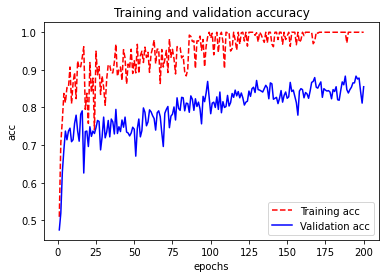

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

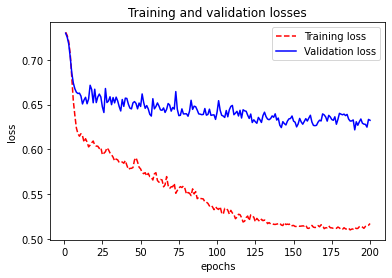

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [ ]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"LossesDataFrame.csv", index=False)

In [49]:
accuracy_dataframe = pd.read_csv(dataframes_path + "AccuracyDataframe.csv")

In [50]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
194,1.000000,0.883333
187,1.000000,0.883333
167,0.975936,0.879487
196,1.000000,0.878205
195,1.000000,0.875641
...,...,...
50,0.891927,0.670513
2,0.766452,0.628205
16,0.961538,0.625641
1,0.705556,0.519231


In [46]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos Resnet/resnet_weights_195.pt')
#checkpoint = torch.load('../input/pesos-melanoma/resnet_weights_60.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [47]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Submission.csv", index=False)

In [48]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[212  66]
 [ 49 214]]
------------Exactitud-------------------
0.7874306839186691
------------Precision-------------------
0.7889382106763712
[0.81226054 0.76428571]
------------Sensibilidad-------------------
0.7874306839186691
[0.76258993 0.81368821]
------------F1 score-------------------
0.7874059899497313
[0.78664193 0.78821363]
